In [1]:
import sys
sys.version

'3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dataset/cleaned.csv')

In [4]:
df

,E,pt,eta,phi
0,1069460.0,751597.0,0.858186,-1.842170
1,457647.0,110079.0,2.102870,2.175010
2,49649.1,30875.2,-1.031890,-1.799200
3,676000.0,640429.0,0.330450,0.704554
4,1239300.0,602104.0,1.343240,-0.550856
...,...,...,...,...
20360,731849.0,722541.0,-0.134499,2.563930
20361,268828.0,259144.0,0.153813,0.578428
20362,153340.0,43931.5,1.920140,-0.237382
20363,893689.0,742040.0,-0.618057,-3.104660


In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

In [6]:
from src.utils import Utilities

In [7]:
df_normalized = df.copy()
df_normalized[df_normalized.columns] = StandardScaler().fit_transform(df_normalized)

In [8]:
df

,E,pt,eta,phi
0,1069460.0,751597.0,0.858186,-1.842170
1,457647.0,110079.0,2.102870,2.175010
2,49649.1,30875.2,-1.031890,-1.799200
3,676000.0,640429.0,0.330450,0.704554
4,1239300.0,602104.0,1.343240,-0.550856
...,...,...,...,...
20360,731849.0,722541.0,-0.134499,2.563930
20361,268828.0,259144.0,0.153813,0.578428
20362,153340.0,43931.5,1.920140,-0.237382
20363,893689.0,742040.0,-0.618057,-3.104660


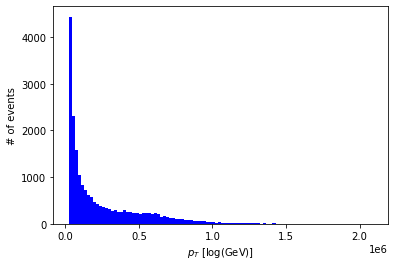

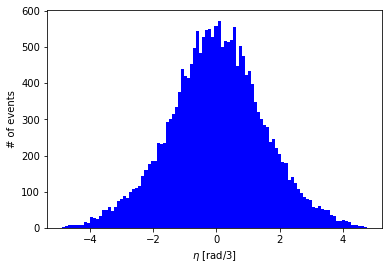

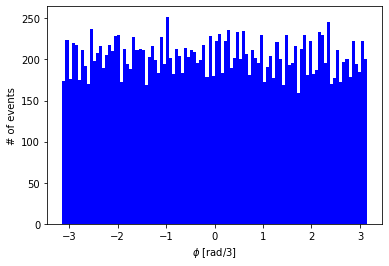

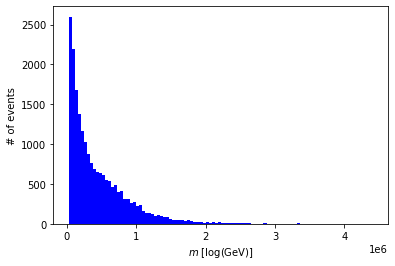

In [9]:
Utilities.plot_hist(df, False)

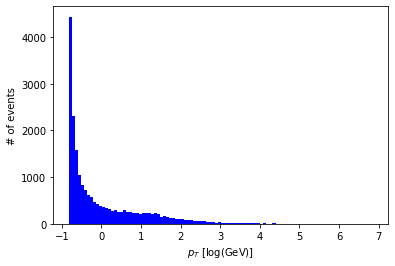

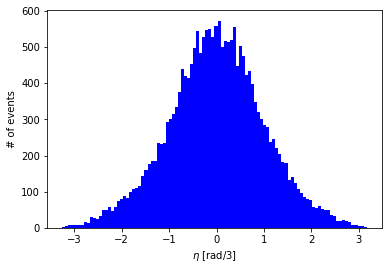

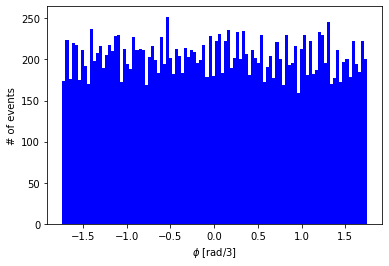

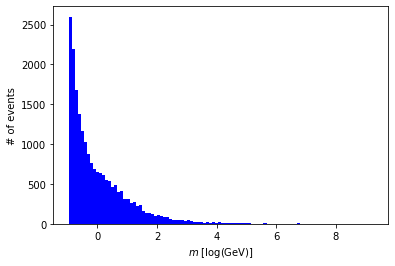

In [10]:
Utilities.plot_hist(df_normalized, False)

In [11]:
# shuffling the data before splitting
df_normalized = shuffle(df_normalized)

# split the data into train and test with a ratio of 20%
train_x, test_x = train_test_split(df_normalized, test_size=0.2, random_state=1)

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(16292, 4)
Test data shape: 
(4073, 4)


In [12]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

# Original Example in repo

In [13]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4, leakyRelu: bool = False):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 100)
        self.en2 = nn.Linear(100, 50)
        self.en3 = nn.Linear(50, 10)
        self.en4 = nn.Linear(10, 3)
        self.de1 = nn.Linear(3, 10)
        self.de2 = nn.Linear(10, 50)
        self.de3 = nn.Linear(50, 100)
        self.de4 = nn.Linear(100, n_features)
        self.relu = leakyRelu
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
    def describe(self):
        return '4-200-200-20-3-20-200-200-4'

In [16]:
class AE_1(nn.Module):
    def __init__(self, n_features=4, leakyRelu: bool = False):
        super(AE_1, self).__init__()
        self.en1 = nn.Linear(n_features, 128)
        self.en2 = nn.Linear(128, 64)
        self.en3 = nn.Linear(64, 32)
        self.en4 = nn.Linear(32, 3)
        self.de1 = nn.Linear(3, 32)
        self.de2 = nn.Linear(32, 64)
        self.de3 = nn.Linear(64, 128)
        self.de4 = nn.Linear(128, n_features)
        self.relu = leakyRelu
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [17]:
model = AE_1()
model.to('cpu')

AE_1(
  (en1): Linear(in_features=4, out_features=128, bias=True)
  (en2): Linear(in_features=128, out_features=64, bias=True)
  (en3): Linear(in_features=64, out_features=32, bias=True)
  (en4): Linear(in_features=32, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=32, bias=True)
  (de2): Linear(in_features=32, out_features=64, bias=True)
  (de3): Linear(in_features=64, out_features=128, bias=True)
  (de4): Linear(in_features=128, out_features=4, bias=True)
  (tanh): Tanh()
)

In [22]:
model_relu = AE_1(4, True)
model_relu.to('cpu')

AE_1(
  (en1): Linear(in_features=4, out_features=128, bias=True)
  (en2): Linear(in_features=128, out_features=64, bias=True)
  (en3): Linear(in_features=64, out_features=32, bias=True)
  (en4): Linear(in_features=32, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=32, bias=True)
  (de2): Linear(in_features=32, out_features=64, bias=True)
  (de3): Linear(in_features=64, out_features=128, bias=True)
  (de4): Linear(in_features=128, out_features=4, bias=True)
  (leakyRelu): LeakyReLU(negative_slope=0.01)
)

Learning rate with the minimum loss: 0.004786301031708717
Learning rate with the steepest gradient: 0.001737800776027143


epoch,train_loss,valid_loss,time
0,0.938679,0.872641,00:00
0,0.938679,0.872641,00:00
1,0.767334,0.606965,00:00
1,0.767334,0.606965,00:00
2,0.556964,0.409613,00:01
2,0.556964,0.409613,00:01
3,0.434694,0.367898,00:01
3,0.434694,0.367898,00:01
4,0.328541,0.185896,00:01
4,0.328541,0.185896,00:01


Training took 116.68006729999979 seconds


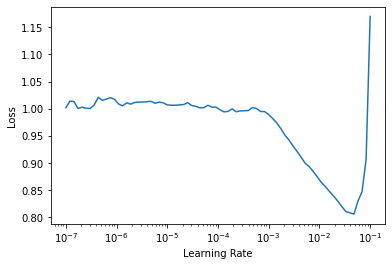

In [18]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

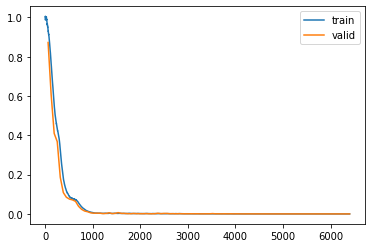

In [19]:
recorder.plot_loss()

In [20]:
learn.validate()

(#1) [6.318230589386076e-05]

In [23]:
loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model_relu, wd=weight_decay, loss_func=loss_function, cbs=recorder)

Learning rate with the minimum loss: 0.010000000149011612
Learning rate with the steepest gradient: 0.009120108559727669


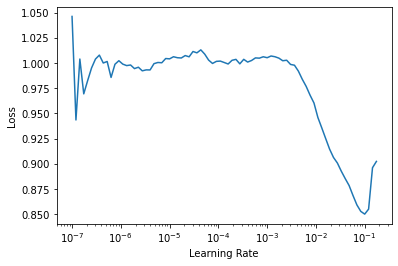

In [24]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [25]:
import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.935053,0.797212,00:01
0,0.935053,0.797212,00:01
1,0.566837,0.323180,00:01
1,0.566837,0.323180,00:01
2,0.249249,0.083587,00:00
2,0.249249,0.083587,00:00
3,0.108693,0.042429,00:00
3,0.108693,0.042429,00:00
4,0.045713,0.014329,00:00
4,0.045713,0.014329,00:00


Training took 122.34995489999983 seconds


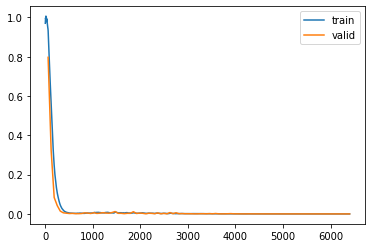

In [27]:
recorder.plot_loss()

In [29]:
learn.validate()

(#1) [6.131424015620723e-05]